In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

pwd = os.getcwd()

In [2]:
total_slices = 17878347

times_combined = pd.DataFrame(
    {
        "files" : [],
        "server_nodes_fraction" : [],
        "server_rpc_xstreams_per_MPI_rank" : [],
        "total_num_nodes" : [],
        "MPI_rank_among_clients" : [],
        "expt_number" : [],
        "analysis_start_times" : [],
        "pep_start_times" : [],
        "pep_end_times" : [],
        "analysis_end_times" : [],
        "analysis_method" : [],
    }
)

df_ssd_hepnos = pd.read_csv("ssd_hepnos/servers_one_eigth/16MPI_ranks_per_node/ssd-hepnos.csv")
df_hepnos = pd.read_csv("hepnos/servers_one_eigth/16MPI_ranks_per_node/map-hepnos.csv")
times_hepnos = pd.concat([times_combined, df_ssd_hepnos, df_hepnos], ignore_index=True)
times_hepnos = times_hepnos.drop(columns=["Unnamed: 0"])
times_hepnos = times_hepnos.assign(throughput = ((total_slices * (times_hepnos["files"]/1929))/
                                                 (times_hepnos["pep_end_times"] - times_hepnos["pep_start_times"])))
times_hepnos = times_hepnos.astype({'total_num_nodes':'int'})
times_hepnos = times_hepnos.astype({'files':'int'})
#times_hepnos = times_hepnos.assign(is_hepnos = int(1))

df_root = pd.read_csv("root/root-hepnos.csv")
df_root = df_root.assign(throughput = ((total_slices * (df_root["files"]/1929))/
                                                 (df_root["analysis_end_times"])))
df_root = df_root.drop(columns=["Unnamed: 0"])
#df_root = df_root.assign(is_hepnos = int(0))

df_root = df_root.astype({'total_num_nodes':'int'})
times_combined = pd.concat([times_combined, df_root, times_hepnos], ignore_index=True)
times_combined = times_combined.astype({'total_num_nodes':'int'})
times_combined = times_combined.astype({'files':'int'})

os.chdir(pwd)

In [3]:
times_combined[(times_combined["total_num_nodes"] == 256) &
               (times_combined["files"] == 1929) &
               (
                   (times_combined["MPI_rank_among_clients"] == 0) | 
                   (times_combined["MPI_rank_among_clients"].isna())
               )
              ]

,files,server_nodes_fraction,server_rpc_xstreams_per_MPI_rank,total_num_nodes,MPI_rank_among_clients,expt_number,analysis_start_times,pep_start_times,pep_end_times,analysis_end_times,analysis_method,throughput
18376,1929,0.125,16.0,256,0.0,1.0,0.000471,3.13705,62.2970,69.8127,HEPnOS-rocksdb,302203.551558
23155,1929,0.125,16.0,256,0.0,2.0,0.000464,3.20944,62.6614,72.8086,HEPnOS-rocksdb,300719.219350
25238,1929,0.125,16.0,256,0.0,3.0,0.000476,3.12125,62.9212,68.7432,HEPnOS-rocksdb,298969.263352
29957,1929,0.125,16.0,256,0.0,4.0,0.000471,3.09963,63.5156,68.8330,HEPnOS-rocksdb,295920.879860
32449,1929,0.125,16.0,256,0.0,5.0,0.000452,3.12009,61.9480,68.9257,HEPnOS-rocksdb,303909.266877
92930,1929,0.125,16.0,256,0.0,1.0,0.000492,2.71234,61.6843,69.3709,HEPnOS-map,303166.911868
98567,1929,0.125,16.0,256,0.0,2.0,0.000478,3.19776,62.1217,69.0079,HEPnOS-map,303413.977409
102267,1929,0.125,16.0,256,0.0,3.0,0.000480,3.35960,63.1755,69.5032,HEPnOS-map,298889.542747
104880,1929,0.125,16.0,256,0.0,4.0,0.000479,3.37822,63.0542,69.9692,HEPnOS-map,299590.337687
106709,1929,0.125,16.0,256,0.0,5.0,0.000431,3.52398,61.7959,70.4134,HEPnOS-map,306808.957041


In [4]:
# Import seaborn
import seaborn as sns
import seaborn.objects as so

# Apply the default theme
sns.set_theme(palette='pastel')

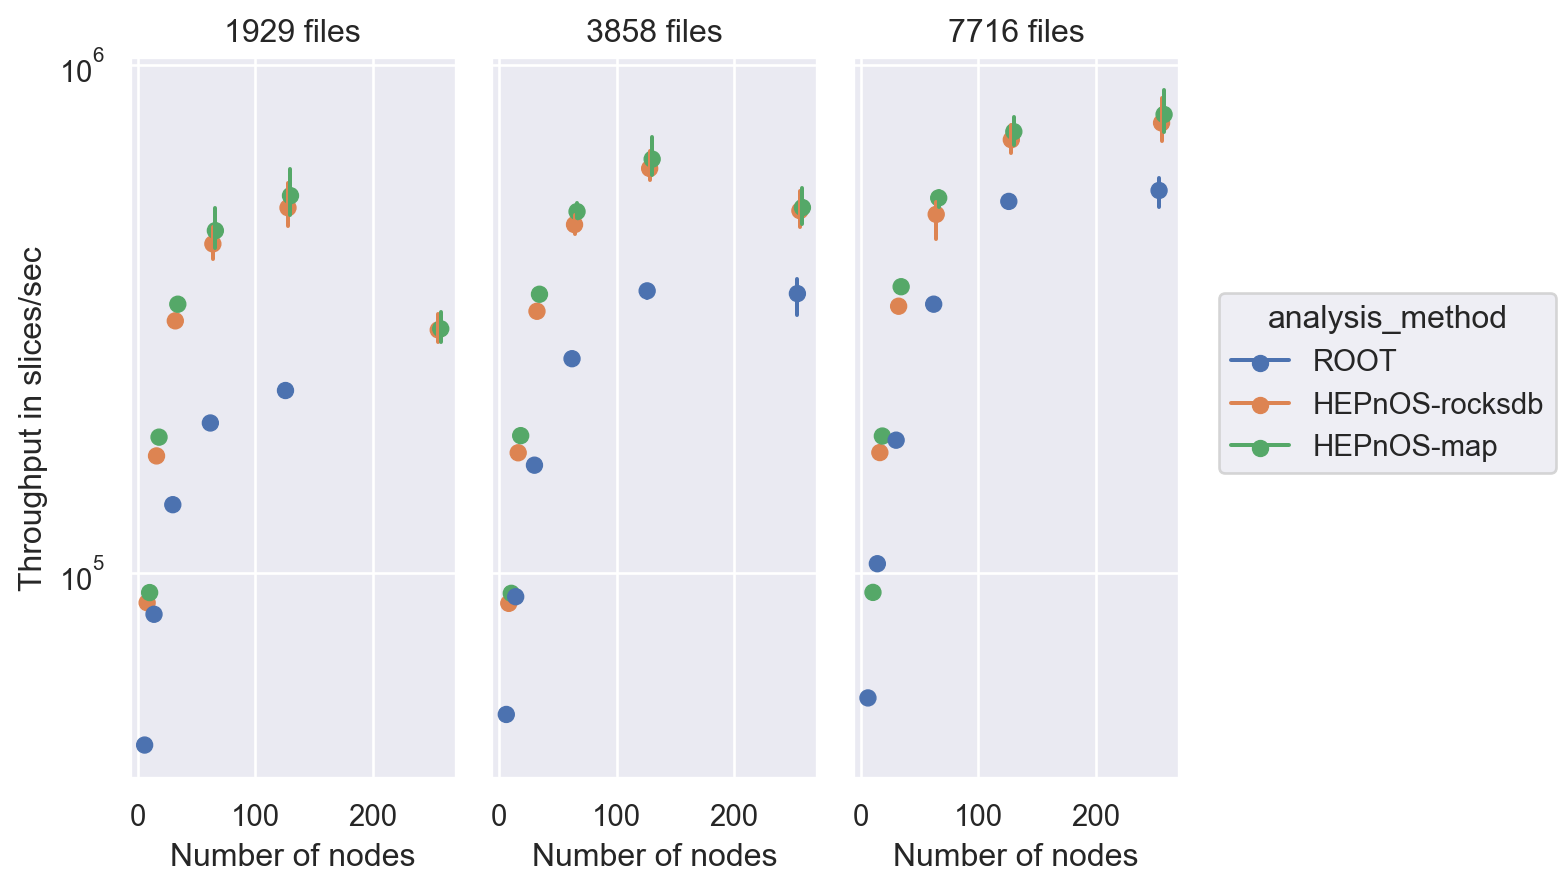

In [5]:
(
so.Plot(times_combined,
    x="total_num_nodes",
    y="throughput",
    color="analysis_method"
    )
    .facet(col="files")
    .add(so.Dot(), so.Est(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="pi"), so.Dodge())
    #.layout(size=(18, 6), engine="tight")
    .scale(y="log")
    .label(x="Number of nodes", y="Throughput in slices/sec", title="{} files".format)
)

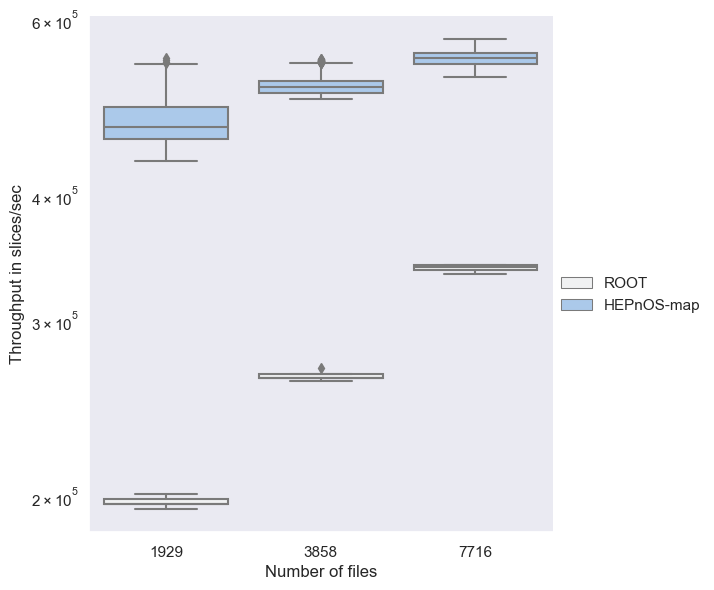

In [6]:
g = sns.FacetGrid(times_combined[(times_combined["total_num_nodes"]== 64) & (times_combined["analysis_method"]!="HEPnOS-rocksdb")], height=6)
g.map_dataframe(sns.boxplot, 
                x="files",
                y="throughput",
                hue="analysis_method",
                dodge=False,
                hue_order = ['ROOT','HEPnOS-map'])
g.set(yscale="log")
g.set_xlabels("Number of files")
g.set_ylabels("Throughput in slices/sec")
g.set_titles("{col_name} files")
g.add_legend()
g.savefig("64_node_throughput.svg", dpi=500, bbox_inches="tight")

In [7]:
#times_hepnos[(times_hepnos["files"]==7716) & (times_hepnos["total_num_nodes"]== 16) & (times_hepnos["analysis_method"] == "HEPnOS-rocksdb") ]

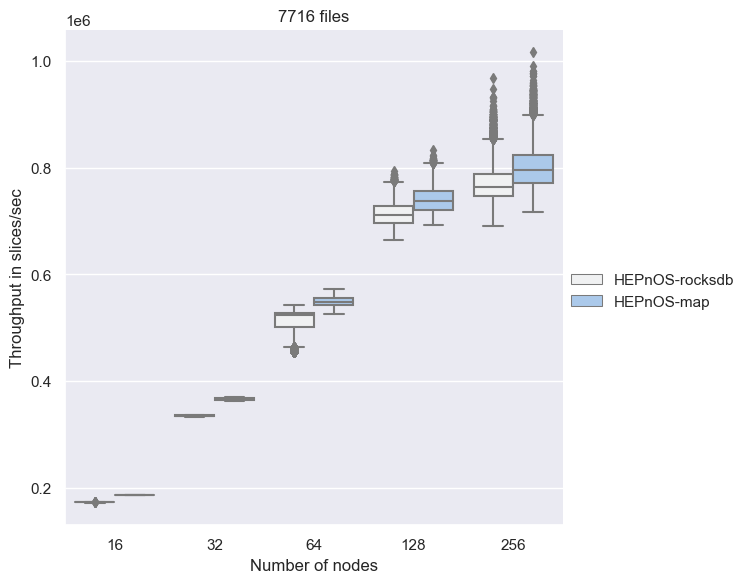

In [8]:
g = sns.FacetGrid(times_hepnos[(times_hepnos["files"]==7716) & (times_hepnos["total_num_nodes"]!=8) ], height=6, col="files")
g.map_dataframe(sns.boxplot, 
                x="total_num_nodes",
                y="throughput",
                hue="analysis_method",
                hue_order = ['HEPnOS-rocksdb', 'HEPnOS-map'])
                #split=True)
#g.set(yscale="log")
g.set_xlabels("Number of nodes")
g.set_ylabels("Throughput in slices/sec")
g.set_titles("{col_name} files")
g.add_legend()
g.savefig("7716_hepnos_throughput.svg", dpi=500, bbox_inches="tight")

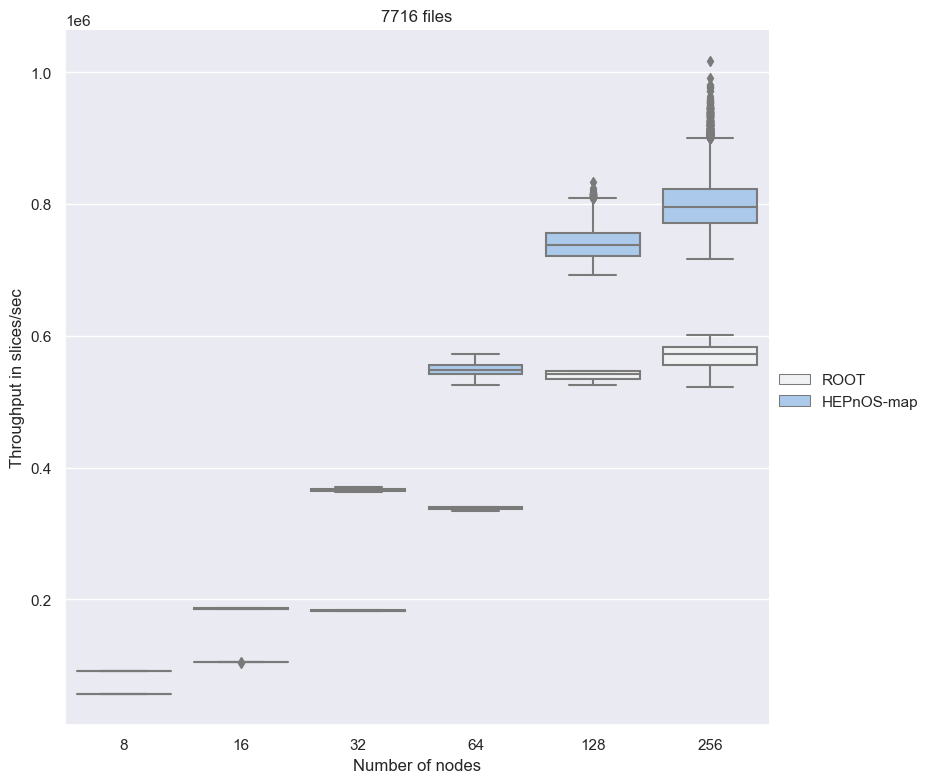

In [9]:
g = sns.FacetGrid(times_combined[(times_combined["files"]==7716) & (times_combined["analysis_method"]!="HEPnOS-rocksdb")], height=8, col="files")
g.map_dataframe(sns.boxplot, 
                x="total_num_nodes",
                y="throughput",
                hue="analysis_method",
                dodge=False)
                #hue_order = ['ROOT', 'HEPnOS-map'])
                #split=True)
#g.set(yscale="log")
g.set_xlabels("Number of nodes")
g.set_ylabels("Throughput in slices/sec")
g.set_titles("{col_name} files")
g.add_legend()
g.savefig("7716_hepnos_rocksdb_root_throughput.svg", dpi=500, bbox_inches="tight")

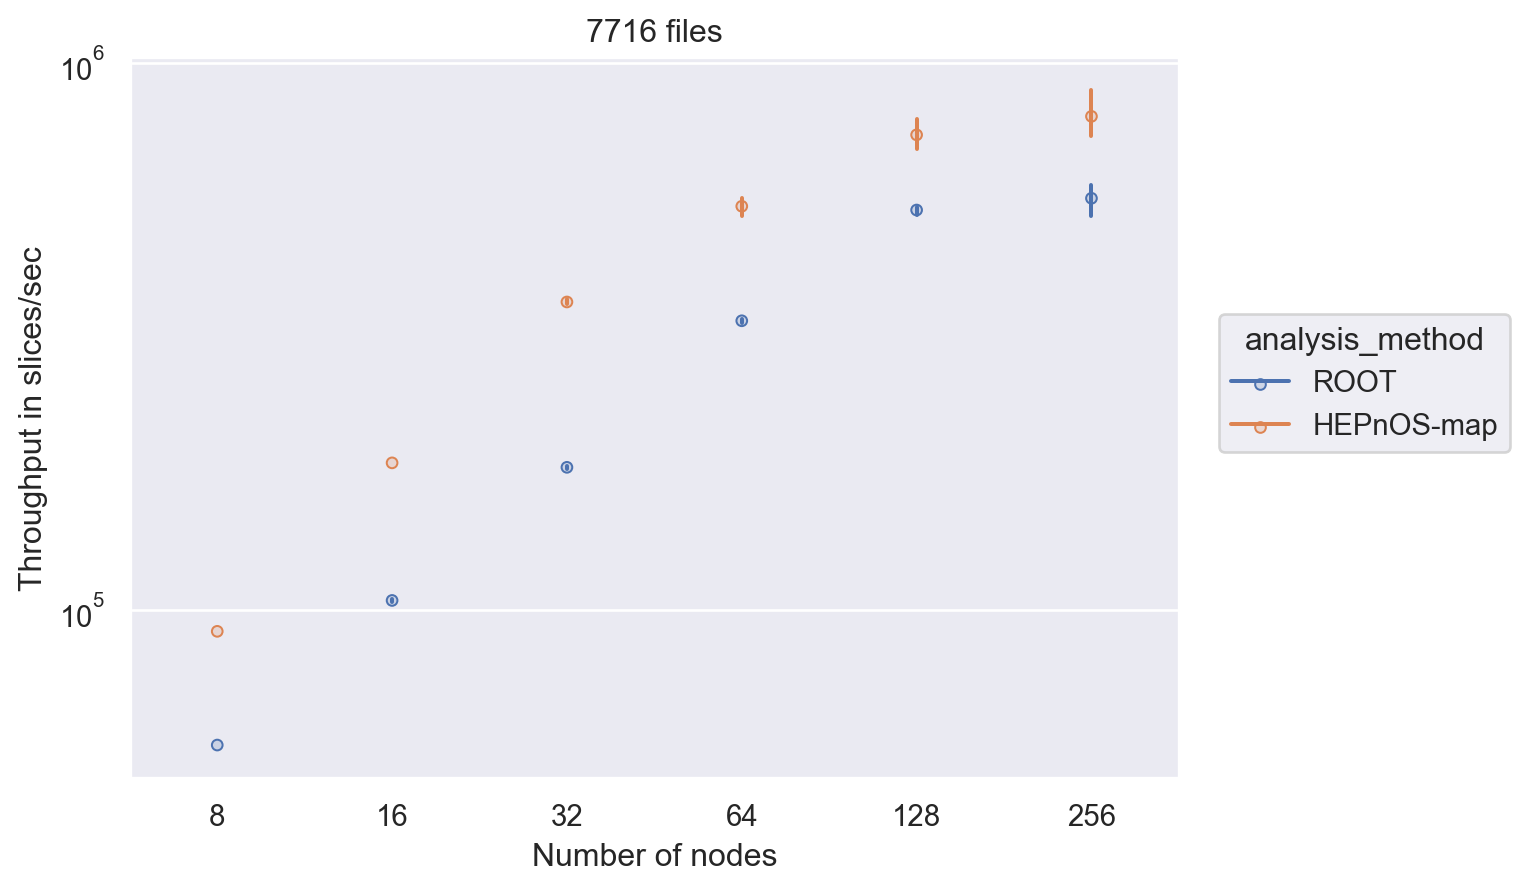

In [10]:
(
so.Plot(times_combined[(times_combined["files"]==7716) & (times_combined["analysis_method"]!="HEPnOS-rocksdb")],
    x="total_num_nodes",
    y="throughput",
    color="analysis_method"
    )
    .add(so.Dots(), so.Agg())
    .add(so.Range(), so.Est(errorbar="pi"))
    .scale(x=so.Nominal())
    .scale(y="log")
    .label(x="Number of nodes", y="Throughput in slices/sec", title="7716 files")
)